In [81]:
import sys, os, logging
sys.path.append('../')
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import pandas as pd
from itertools import product
from matplotlib import rcParams
from tvb.simulator.lab import *
logging.getLogger('tvb.basic.readers').setLevel(logging.ERROR)
import scipy.stats as st
from utils.metrics import fcd_sim, gap
import utils.pci as pci
rcParams['figure.figsize'] = 15,6
rcParams.update({'font.size': 24})
pd.set_option('display.max_rows', 100)


In [4]:
pcis = pd.read_csv('../data/interim/simulation_pcis.csv')
fluidity = pd.read_csv('../data/interim/simulation_fluidity.csv')

In [6]:
pcis.head()

,node,onset,coupling,noise,pci,lz,norm_factor,ratio,lz_ratio,nf_ratio,pci_rel
0,8.0,1000.0,0.25,0.022,0.050651,6.0,118.45724,0.623224,1.200000,1.925471,0.376776
1,8.0,1000.0,0.25,0.024,0.018126,9.0,496.52014,1.023597,1.125000,1.099065,0.023597
2,8.0,1000.0,0.25,0.026,0.022916,12.0,523.65063,0.998538,1.090909,1.092507,0.001462
3,8.0,1000.0,0.25,0.028,0.021526,18.0,836.19430,1.006677,1.058824,1.051800,0.006677
4,8.0,1000.0,0.25,0.030,0.019973,34.0,1702.28660,1.008254,1.030303,1.021869,0.008254


In [13]:
fluidity.head()

,coupling,noise,fluidity_var,V_max_gradient,V_max_gradient_sq,V_max_gradient_sq_z,V_max_gradient_sq_z_abs,r_max_gradient,r_max_gradient_sq,r_max_gradient_sq_z,cascade_quanti,n_states
0,0.25,0.020,0.000111,0.129390,0.346571,6.767658,8.101715,0.151698,0.323480,14.294330,615.59160,75.0
1,0.25,0.022,0.000115,0.136879,0.364273,7.642137,8.317555,0.174550,0.353664,13.750468,716.00040,108.0
2,0.25,0.024,0.000111,0.145569,0.380504,7.069736,7.371469,0.208625,0.398503,12.943081,788.57930,170.0
3,0.25,0.026,0.000111,0.151186,0.386095,6.488313,6.843857,0.229071,0.435225,12.083039,793.25415,361.0
4,0.25,0.028,0.000103,0.163192,0.376993,6.713984,6.713984,0.233776,0.434480,9.658793,847.64070,659.0


[0.024 0.036 0.048]


/var/folders/ht/k1bq940j1nzdxy0vc8gf2_d40000gn/T/ipykernel_26042/2789577036.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([fr'$10^{{{int(np.floor(np.log10(i)))}}}$' for i in ticks])


(array([0.024, 0.036, 0.048]), [])

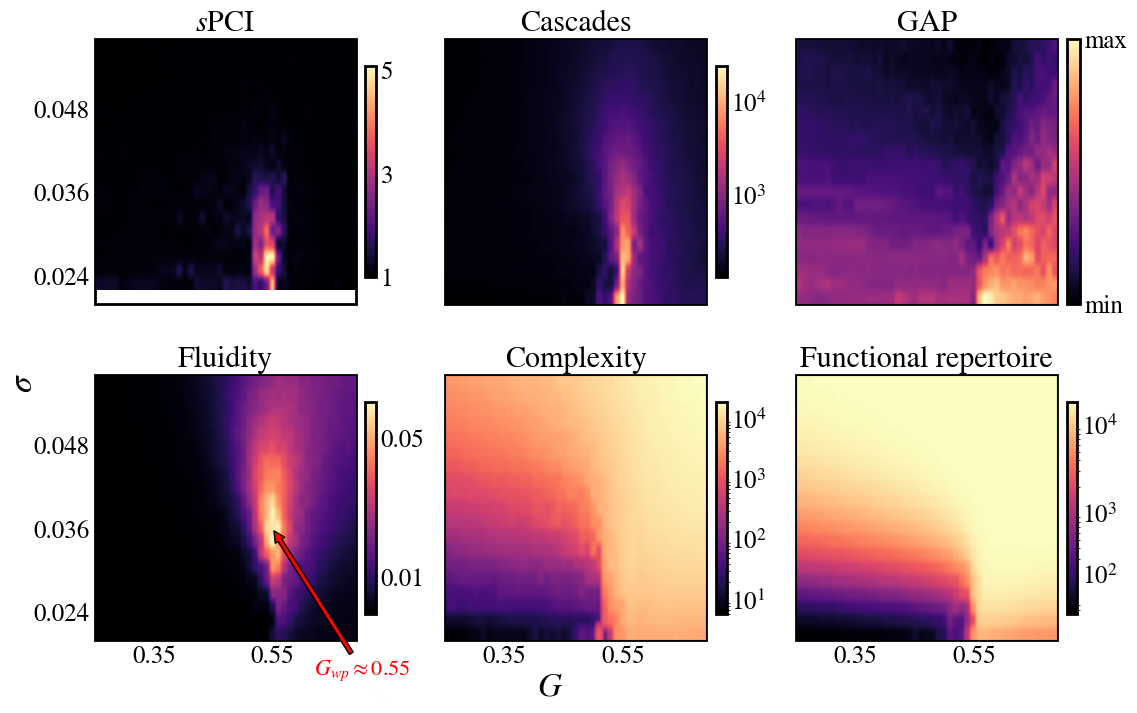

In [12]:
from matplotlib import colors
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=18
matplotlib.rcParams['figure.labelsize']=24
plt.style.use('_mpl-gallery')

fig, axes = plt.subplots(2,3, figsize=(12, 8), sharex=True, sharey=True)
(ax1, ax2, ax3), (ax4, ax5, ax6) = axes
shrink_factor = .8
padding = 0.03

# PCI
to_plot = pcis[pcis.node!=-1].groupby(['noise', 'coupling']).agg({'ratio': lambda x: x.max(skipna=True)})
to_plot = to_plot.reset_index().pivot(index='noise', columns='coupling', values='ratio')
g = ax1.imshow(to_plot, cmap='magma', extent=[.25, .69, .058, .022], aspect='auto', interpolation='kaiser')
cbar = fig.colorbar(g, ax=ax1, location='right', shrink=shrink_factor, pad=padding)
ax1.set_title(r'$s$PCI')
ax1.invert_yaxis()
cbar.set_ticks([1, 3, 5])
cbar.set_ticklabels([1, 3, 5])
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)
ax1.patch.set_edgecolor('black')  
ax1.patch.set_linewidth(2)
ax1.set_xticks([.35, .55], [.35, .55])
ax1.set_yticks([.024, .036, 0.048], [.024, .036, 0.048])

# FLUIDITY
to_plot = fluidity.groupby(['coupling', 'noise'])['fluidity_var'].mean().reset_index().pivot(index='noise', columns='coupling', values='fluidity_var')#.iloc[::-1, :]
g = ax4.imshow(to_plot, cmap='magma', extent=[.25, .69, .058, .02], aspect='auto', interpolation='kaiser')
ax4.set_title('Fluidity')
cbar = fig.colorbar(g, ax=ax4, location='right', shrink=shrink_factor, pad=padding)
print(ax4.get_yticks())
ax4.invert_yaxis()
cbar.set_ticks([to_plot.min().min()+0.01, to_plot.max().max()-0.01])
cbar.set_ticklabels([(to_plot.min().min()+0.01).round(2), (to_plot.max().max()-0.01).round(2)])
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)
ax4.patch.set_edgecolor('black')  
ax4.patch.set_linewidth(2)
ax4.annotate(r'$G_{wp}\approx 0.55$', xy=(.55, 0.036), xytext=(.62, 0.015), c='red',
            arrowprops=dict(arrowstyle='simple',facecolor='red', edgecolor='black', linewidth=1), xycoords='data', size=16
            )



# COMPLEXITY
to_plot = pcis.groupby(['noise', 'coupling']).agg({'lz': lambda x: x.max(skipna=True)})
to_plot = to_plot.reset_index().pivot(index='noise', columns='coupling', values='lz')#.iloc[::-1, :]
mask = to_plot.isnull()
g = ax5.imshow(to_plot,cmap='magma', extent=[.25, .69, .058, .02], aspect='auto', interpolation='kaiser', norm=mpl.colors.LogNorm())#, vmin=.95, vmax=1.15)
ax5.set_title('Complexity')
ax5.invert_yaxis()
cbar = fig.colorbar(g, ax=ax5, location='right', shrink=shrink_factor, pad=padding)
cbar.set_ticks([10, 100, 1000, 10000])
# cbar.set_ticklabels([r'min', r'max'])
ticks = [t for t in cbar.get_ticks()]
cbar.set_ticklabels([fr'$10^{{{int(np.floor(np.log10(i)))}}}$' for i in ticks])
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)
ax5.patch.set_edgecolor('black')  
ax5.patch.set_linewidth(2)

# REPERTOIRE
to_plot = fluidity.groupby(['noise', 'coupling']).agg({'n_states': lambda x: x.max(skipna=True)})
to_plot = to_plot.reset_index().pivot(index='noise', columns='coupling', values='n_states')#.iloc[::-1, :]
g = ax6.imshow(to_plot, cmap='magma', extent=[.25, .69, .058, .02], aspect='auto', interpolation='kaiser', norm=mpl.colors.LogNorm())#, vmin=.95, vmax=1.15)
ax6.set_title('Functional repertoire')
ax6.invert_yaxis()
cbar = fig.colorbar(g, ax=ax6, location='right', shrink=shrink_factor, pad=padding)
# cbar.set_ticks([to_plot.min().min(), to_plot.max().max()])
# cbar.set_ticklabels([r'min', r'max'])
cbar.set_ticks([200, 1000, 10000])
# cbar.set_ticklabels([r'min', r'max'], size=20)
ticks = [t for t in cbar.get_ticks()]
cbar.set_ticklabels([fr'$10^{{{int(np.floor(np.log10(i)))}}}$' for i in ticks])
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)
ax6.patch.set_edgecolor('black')
ax6.patch.set_linewidth(2)


padding = 0.03
to_plot = fluidity.groupby(['coupling', 'noise'])['V_max_gradient_sq_z'].mean().reset_index().pivot(index='noise', columns='coupling', values='V_max_gradient_sq_z')
g = ax3.imshow(to_plot, cmap='magma', extent=[.25, .69, .058, .02], aspect='auto', interpolation='kaiser')
ax3.set_title('GAP')
# ax3.set_ylabel(r'$\sigma$')

ax3.invert_yaxis()
cbar = fig.colorbar(g, ax=ax3, location='right', shrink=1, pad=padding)
cbar.set_ticks([to_plot.min().min(), to_plot.max().max()])
cbar.set_ticklabels([to_plot.min().min().round(2), to_plot.max().max().round(2)])
cbar.set_ticks([to_plot.min().min(), to_plot.max().max()])
cbar.set_ticklabels([r'min', r'max'])
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)
ax3.patch.set_edgecolor('black')
ax3.patch.set_linewidth(2)


# BURSTING
to_plot = fluidity.groupby(['coupling', 'noise'])['cascade_quanti'].mean().reset_index().pivot(index='noise', columns='coupling', values='cascade_quanti')
g = ax2.imshow(to_plot, cmap='magma', extent=[.25, .69, .058, .02], aspect='auto', interpolation='kaiser')
cbar = fig.colorbar(g, ax=ax2, location='right', shrink=shrink_factor, pad=padding)
ax2.set_title('Cascades')
ax2.invert_yaxis()

# cbar.set_ticks([5, 10])
# cbar.set_ticklabels([5, 10])
cbar.set_ticklabels([fr'$10^{{{int(np.floor(np.log10(i)))}}}$' for i in ticks])
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)
ax2.patch.set_edgecolor('black')  
ax2.patch.set_linewidth(2)  



# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
[ax.grid(False) for ax in axes.ravel()]
# fig.text(0.5, 0, r'$g$', ha='center')
fig.supylabel(r'$\sigma$', va='center', rotation='vertical', x=0.05)
fig.supxlabel(r'$G$', ha='center', y=0.1)

fig.subplots_adjust(wspace=0, hspace=0)

fig.tight_layout()
plt.yticks(rotation=0)

## After generating pci simulations:

In [130]:
baselines = []
stims = []
for f in os.listdir('../results/stimulations'):
    if 'stim' in f:
        stim = {}
        
        stim['coupling'] = float(f.split('_')[3][1:])
        stim['noise'] = float(f.split('_')[4][4:-4])
        stim['node'] = int(f.split('_')[1][1:])
        stim['onset'] = int(f.split('_')[2][5:])

        base_pci = np.load(f'../results/stimulations/baseline_onset{stim['onset']}_G{stim['coupling']}_nsig{stim['noise']}.npz')['pci']
        base_lz = np.load(f'../results/stimulations/baseline_onset{stim['onset']}_G{stim['coupling']}_nsig{stim['noise']}.npz')['lz']
        base_nf = np.load(f'../results/stimulations/baseline_onset{stim['onset']}_G{stim['coupling']}_nsig{stim['noise']}.npz')['nf']
        stim['pci'] = np.load(f'../results/stimulations/{f}')['pci'].ravel()[0]/base_pci
        stim['lz'] = np.load(f'../results/stimulations/{f}')['lz'].ravel()[0]/base_lz
        stim['nf'] = np.load(f'../results/stimulations/{f}')['nf'].ravel()[0]/base_nf
        stims.append(stim)

## After generating resting-state simulations:

In [84]:
GS = np.arange(0.25,0.70,0.01)
SIGS = np.arange(0.02,0.060,0.002)
FOLDER = '../results/resting-state-simulations/'
fluidity = []
sfreq = 1000/32
for g, sig in product(GS, SIGS):
    point = {}
    tavg = np.load(f'{FOLDER}/downsampled_hcp-001_st_G{g:.3f}_nsig{sig:.3f}_tavg_r_and_v.npz')
    FCD, fcs = fcd_sim(tavg['tavg_d'][:,0,:,0], win_len=int(sfreq*30), win_sp=int(sfreq*5))
    k = ((int(sfreq*3)-int(sfreq*1))/(int(sfreq*1)))+1
    triangle = np.triu(FCD, int(k))
    point['coupling'] = g
    point['noise'] = sig
    point['fluidity_var'] = np.var(triangle)
    point['max_gradient'] = gap(tavg['tavg_d'][:,1,:,0].T)
    
    point['cascade_quanti'] = np.sum(np.abs(np.convolve(st.zscore(tavg['tavg_d'][:,0,:,0], axis=0).mean(axis=1), np.ones(100)/100)))

    Zbin=np.where(tavg['tavg_d'][:,0,:,0]>.7,1,0)
    point['complexity'] = pci.lz_complexity_2D(Zbin)

    Zbin=np.reshape(Zbin,(-1,2,84))
    Zbin=np.where(np.sum(Zbin,axis=1)>0,1,0)
    point['n_states'] = np.unique(Zbin.T, axis=1).shape[1]
    fluidity.append(point)
fluidity = pd.DataFrame.from_dict(list(fluidity))
fluidity.coupling = fluidity.coupling.round(4)
fluidity.noise = fluidity.noise.round(4)

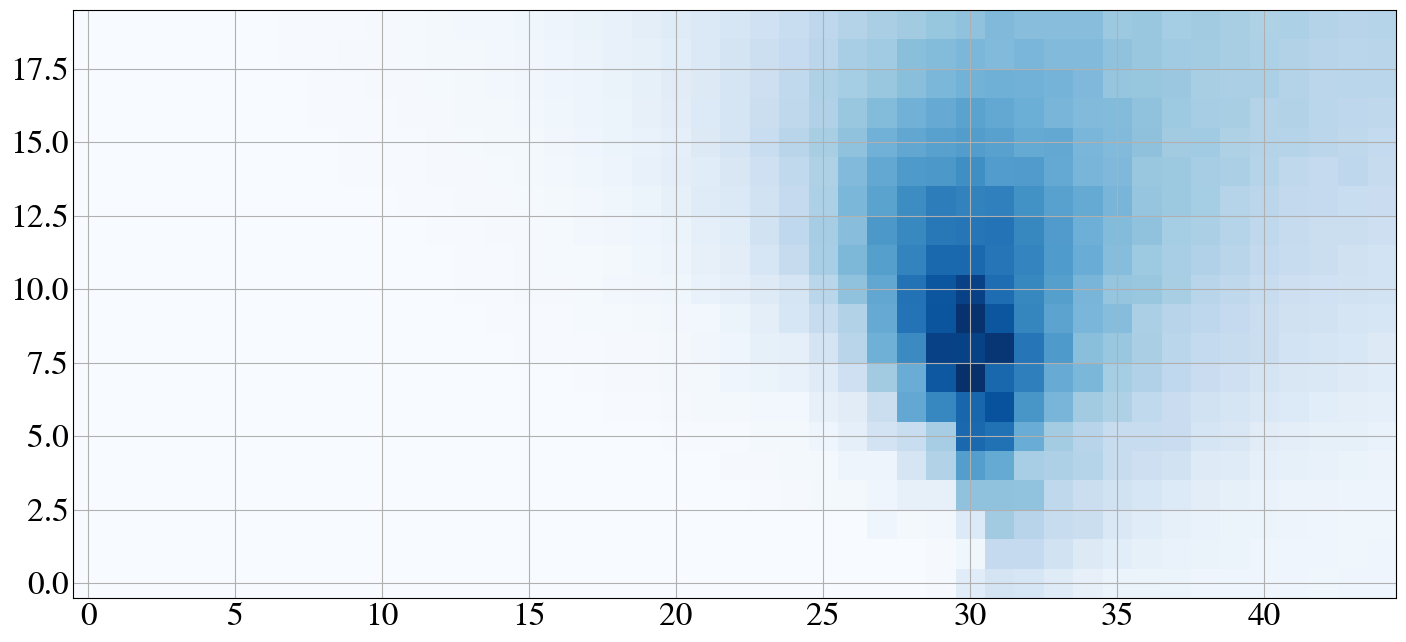

In [70]:
fig, ax = plt.subplots(1,1)
ax.imshow(fluidity.pivot(index='noise', columns='coupling', values='fluidity_var'))
ax.invert_yaxis()

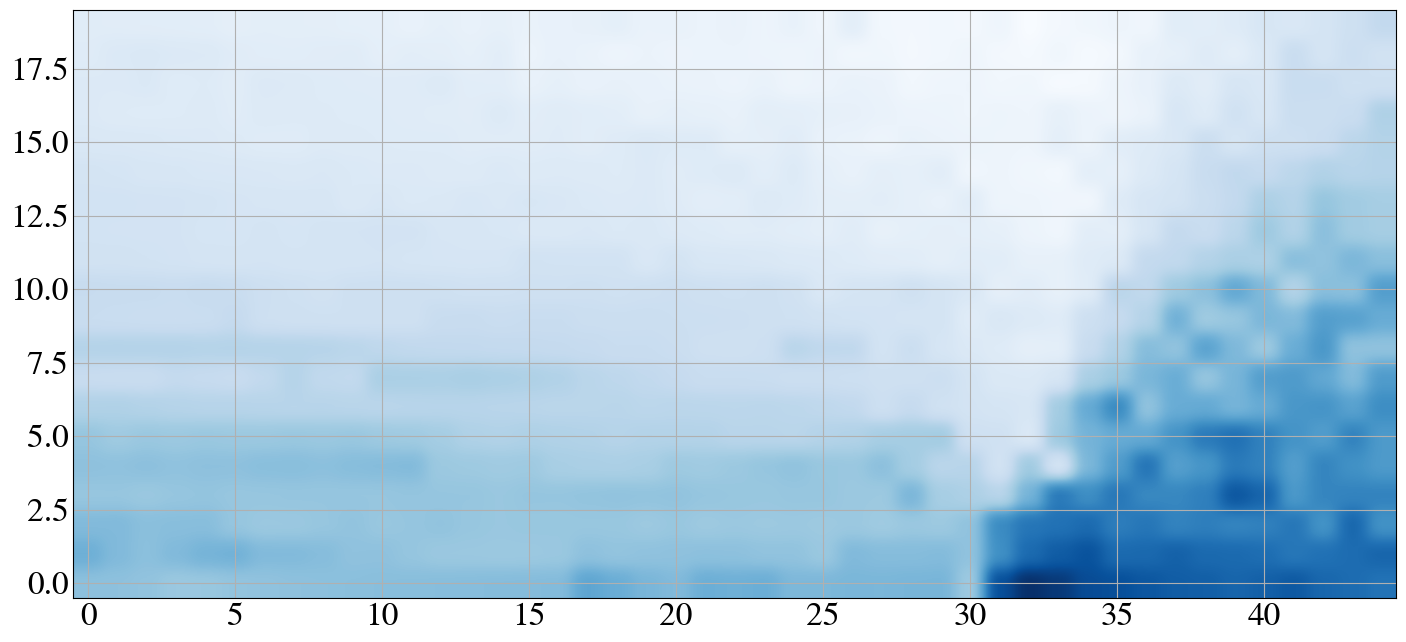

In [76]:
fig, ax = plt.subplots(1,1)
ax.imshow(fluidity.pivot(index='noise', columns='coupling', values='max_gradient'), interpolation='kaiser')
ax.invert_yaxis()